#**Notebook de Maintenance** : 




# **Sommaire** :     

[1.Fonctions utilisées](#Pr)

[2.Maintenance temporelle](#Imports)
  




<a name="Pr"></a>
# 1. **Fonctions utilisées** 

*Voici les différentes fonctions utilisées dans ce Notebook :*

In [58]:
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

import datetime as dt

from yellowbrick.cluster import KElbowVisualizer

from sklearn.cluster import DBSCAN

In [59]:
use_colab = True 

if use_colab:
  from google.colab import drive
  drive.mount('/content/drive')
  path ='/content/drive/MyDrive/'
else:
  path='/data/'

data = pd.read_csv(path + 'rfm_export.csv')
data_variables = pd.read_csv(path + 'rfm_export_bis.csv')
data_variables_2 = pd.read_csv(path + 'rfm_export_bis_new.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import adjusted_rand_score, silhouette_score 
from sklearn.metrics import davies_bouldin_score
import pandas as pd 
import numpy as np
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

from yellowbrick.cluster import SilhouetteVisualizer

# style par défaut
style_plot = "seaborn-darkgrid"
plt.style.use(style_plot)



def normalize_data(df,
                   plot_transformation=False,
                   rounded=3,
                   one_hot_encoder=None,
                   label_encoder=None,
                   log_col=False,
                   scaler=None):
  
    """Cette function permet de normaliser les donnée avec plusieurs option 
      possibles comme un one_hot_encoder, label_encoder et la mise au log 
      des variables,pour le scaler, par défaut l'algorithme utilise le 
      StandardScaler de sklearn, il est possible d'ajouter un autre scaler 
      de scikit-learn.
        
        
        Parameters
        ----------
        df : pd.DataFrame, 
            pandas DataFrame du jeu de données d'apprentissage à transformer.
            
        Optional
        ----------
        plot_transformation : bool, default=False
            Indique si l'algorithme affiche la transformation des variables 
            log effectuées.
            
        rounded : int, default=3,
            Arrondi les chiffres lors de la mise au log.
            
        one_hot_encoder : list, default=None
            Indique les colonnes où on applique l'encode one_hot_encoder.
            
        label_encoder : list, default=None
            Indique les colonnes où on applique l'encode label_encoder.
            
        log_col : bool, default=False
            Indique si on applique la mise au log des variables.
            
        scaler : Scaler (sklearn), default=None (StandardScaler)
            Permet de modifier le scaler par défaut (si None),
           il est possible de rajouter n'importe quelle Scaler
           de la librairie scikit-learn.
                        
        Returns
        -------
        df_normalize, pd.DataFrame,
 Renvoie un DataFrame normalisé selon les critéres définies dans les paramètres.
    """
    cols = df.columns.tolist()
        
    df_normalize = df[cols].copy()
    all_object_encode = []
    
    if not one_hot_encoder is None:
        # Encode col
        all_object_encode.extend(one_hot_encoder)
        df_normalize = pd.get_dummies(df_normalize, columns=one_hot_encoder,
                                                             dummy_na=False)
        all_new_col = [col for col in temp.columns if not col in cols]
        all_object_encode.extend(all_new_col)
    
    if not label_encoder is None:
        encoder_label = LabelEncoder()
        all_object_encode.extend(label_encoder)
        # Encode col et écrire les labels associés
        for label_col in label_encoder:
            print(label_col)
            df_normalize[label_col] = encoder_label.fit_transform(
                                           df_normalize[label_col]) 
            print({classe:index for index,classe in zip(range(
              len(encoder_label.classes_)),list(encoder_label.classes_))})
            

    
    
    col_not_object =  [col for col in cols if not col in all_object_encode]
    
    if log_col:
        # On enleve les valeurs négatives et les égales à 0 pour la mise au log
        df_normalize[col_not_object] = df_normalize[col_not_object].applymap(
                                                lambda x : 1 if x <= 0 else x)
        df_normalize[col_not_object] = df_normalize[col_not_object].apply(
                                             np.log,axis=1).round(rounded)



    if scaler is None:
        scaler = StandardScaler()
    
    X = np.abs(df_normalize[col_not_object])
    X_scaled = scaler.fit_transform(X)
    df_normalize[col_not_object] = X_scaled
    
    if plot_transformation:
        for col in col_not_object:
            fig, axes = plt.subplots(1,2,figsize=(20,5))
            sns.distplot(df[col],ax=axes[0])
            axes[0].set_title(col + " | Before")
            sns.distplot(df_normalize[col],ax=axes[1])
            axes[1].set_title(col + " | After")
            plt.show()
    
    return df_normalize


############ Satilité des clusters 

def prediction_multilabel(kmeans,X_test):
    """Cette function permet de prédire sur la base de la distance euclidien
       les centroids de l'algorithme KMeans (sklearn) le plus proche
        Parameters
        ----------
        kmeans : KMeans() (sklearn), 
            Algorithme de kmeans utilisé.
            
        X_test : pd.DataFrame, 
            pandas DataFrame du jeu de données à prédire.
            
        Returns
        -------
        prediction, np.array,
           Renvoie une liste numpy contenant les prédictions.    
    """
    if kmeans.cluster_centers_.shape[1] != X_test.shape[1]:
        Exception()
    return X_test.apply(lambda row : get_best_cluster(kmeans,row.values),
                                                            axis=1).values


def get_best_cluster(kmeans,values):
    """Cette function cherche le meilleur cluster pour un point données
        Parameters
        ----------
        kmeans : KMeans() (sklearn), 
            Algorithme de kmeans utilisé.
            
        values : np.array, 
            Numpy array, vecteur individue (individu à prédire).
            
        Returns
        -------
        prediction, float,
           Renvoie l'index du meilleur cluster.    
    """
    minimum=999999999
    best_clust=0
    for cluster_index, centroid in zip(range(len(kmeans.cluster_centers_)),
                                                  kmeans.cluster_centers_):
        dist = calcul_distance(values,centroid)
        if dist <= minimum:
            best_clust = cluster_index
            minimum = dist
    return best_clust

def stability_cluster_one_year(dataframe,
                               col_data,
                               random_state=42,
                               n_cluster=5,
                               recence_col="R",
                               plot_score_ari=True,
                               ceil_stability=0.5,
                               figsize=(9,7)
                                ):
    """Cette fonction permet de calculer la stabilité du clustering dans le temps
  (sur 1 an) cette fonction utilise un algorithme de KMeans par défaut.
  Le scoring est effectuer avec l'ARI (Adjuster Random Index) qui compare 
  par pair les similarités de cluster (avec un score de 1 pour une ressemblance 
  parfaite et négatif pour des clusters totalement différent). 
  Par example : ARI([0,0,1,1],[1,1,0,0]) = 1.0
    
        Parameters
        ----------
        dataframe : pd.DataFrame, 
            pandas DataFrame du jeu de données d'apprentissage (non normalisé).
            
        col_data : list, 
            Liste des noms de colonnes.
            
        Optional
        ----------
        random_state : int, default=42
            Indique si l'algorithme affiche la transformation des
            variables log effectuées.
            
        n_cluster : int, default=5,
            Indique le nombre de cluster choisi pour l'algorithme de KMeans.
            
        recence_col : str, default='R'
            Indique le nom de la colonne de récence 'R' de 'RFM'
            
        plot_score_ari : bool, default=True
            Permet d'afficher un graphique des résultats pour un meilleur rendu
            
        ceil_stability : float, default=0.85
            Indique le seuil a afficher sur le graphique pour définir la
            stabilité du clustering dans le temps.
            
        figsize : tulpe, default=(9,7)
            Indique les dimensions du graphique.
                        
        Returns
        -------
        df_result, pd.DataFrame,
           Renvoie un DataFrame contenant les résultats.
    """
    all_freq_update = [30,60,90,120,150,180,210,240,270,300,330,360] 
    last_train = 360
    
    # plus grande portion possible car plus petite section
    max_sample = dataframe[(dataframe[recence_col] <= last_train) & \
            (dataframe[recence_col] > last_train - all_freq_update[0])].shape[0] 

    store_score_ari_test = []

    before = dataframe[dataframe[recence_col] > last_train]
    X_train = before[col_data]

    X_train = normalize_data(X_train,log_col=True)

    kmeans_before = KMeans(n_clusters=n_cluster)
    kmeans_before.fit(X_train)

    for freq in all_freq_update:
      # plage entre ]360 - freq ; 360]  (freq =1,2,3,4,5,6,7,8,9,10,11,12 mois)
        
        after = dataframe[(dataframe[recence_col] > last_train - freq)]
        
        X_test = after[col_data]
        X_test = normalize_data(X_test,log_col=True)

        kmeans_after = KMeans(n_clusters=n_cluster)
        kmeans_after.fit(X_test)

        # prédiction sur la distance des centroids
        y_true = prediction_multilabel(kmeans_before,X_test)
        y_pred = prediction_multilabel(kmeans_after,X_test)

        store_score_ari_test.append(adjusted_rand_score(y_true,y_pred))
        
    if plot_score_ari:
        plt.style.use(style_plot)
        plt.figure(figsize=figsize)
        plt.title("Stabilité des clusters dans le temps")
        plt.plot([i if i!=0 else 1  for i in range(1,13,1)],
                           store_score_ari_test,marker="o")
        plt.plot([i if i!=0 else 1  for i in range(1,13,1)],
                 [ceil_stability for i in range(1,13,1)],
                 ls="--", c="r", label="Limite stabilité clustering")
        plt.legend()

        plt.xlabel("Nombre de mois")
        plt.ylabel("ARI-score")
        plt.show()
        
    return pd.DataFrame([
              ["1 mois","2 mois","3 mois","4 mois","5 mois","6 mois","7 mois",
               "8 mois","9 mois","10 mois","11 mois","1 ans"],
              store_score_ari_test
             ],
             index=[
                    "Fréquence",
                    "Ari_score"
                   ]).T

In [62]:
def stability_cluster_one_year_delayed(dataframe,
                               col_data,
                               random_state=42,
                               n_cluster=5,
                               recence_col="R",
                               plot_score_ari=True,
                               ceil_stability=0.5,
                               figsize=(9,7)
                                ):
    """Cette fonction permet de calculer la stabilité du clustering dans le temps
  (sur 1 an) cette fonction utilise un algorithme de KMeans par défaut.
  Le scoring est effectuer avec l'ARI (Adjuster Random Index) qui compare 
  par pair les similarités de cluster (avec un score de 1 pour une ressemblance 
  parfaite et négatif pour des clusters totalement différent). 
  Par example : ARI([0,0,1,1],[1,1,0,0]) = 1.0
    
        Parameters
        ----------
        dataframe : pd.DataFrame, 
            pandas DataFrame du jeu de données d'apprentissage (non normalisé).
            
        col_data : list, 
            Liste des noms de colonnes.
            
        Optional
        ----------
        random_state : int, default=42
            Indique si l'algorithme affiche la transformation des
            variables log effectuées.
            
        n_cluster : int, default=5,
            Indique le nombre de cluster choisi pour l'algorithme de KMeans.
            
        recence_col : str, default='R'
            Indique le nom de la colonne de récence 'R' de 'RFM'
            
        plot_score_ari : bool, default=True
            Permet d'afficher un graphique des résultats pour un meilleur rendu
            
        ceil_stability : float, default=0.85
            Indique le seuil a afficher sur le graphique pour définir la
            stabilité du clustering dans le temps.
            
        figsize : tulpe, default=(9,7)
            Indique les dimensions du graphique.
                        
        Returns
        -------
        df_result, pd.DataFrame,
           Renvoie un DataFrame contenant les résultats.
    """
    all_freq_update = [30,60,90,120,150,180,210,240,270,300,
                       330,360,390,420,450,480,510,540] 
    last_train = 540
    
    # plus grande portion possible car plus petite section
    max_sample = dataframe[(dataframe[recence_col] <= last_train) & \
            (dataframe[recence_col] > last_train - all_freq_update[0])].shape[0] 

    store_score_ari_test = []

    before = dataframe[dataframe[recence_col] > last_train]
    X_train = before[col_data]

    X_train = normalize_data(X_train,log_col=True)

    kmeans_before = KMeans(n_clusters=n_cluster)
    kmeans_before.fit(X_train)

    for freq in all_freq_update:
      # plage entre ]360 - freq ; 360]  (freq =1,2,3,4,5,6,7,8,9,10,11,12 mois)
        
        after = dataframe[(dataframe[recence_col] > last_train - freq)]
        
        X_test = after[col_data]
        X_test = normalize_data(X_test,log_col=True)

        kmeans_after = KMeans(n_clusters=n_cluster)
        kmeans_after.fit(X_test)

        # prédiction sur la distance des centroids
        y_true = prediction_multilabel(kmeans_before,X_test)
        y_pred = prediction_multilabel(kmeans_after,X_test)

        store_score_ari_test.append(adjusted_rand_score(y_true,y_pred))
        
    if plot_score_ari:
        plt.style.use(style_plot)
        plt.figure(figsize=figsize)
        plt.title("Stabilité des clusters dans le temps")
        plt.plot([i if i!=0 else 1  for i in range(1,19,1)],
                           store_score_ari_test,marker="o")
        plt.plot([i if i!=0 else 1  for i in range(1,19,1)],
                 [ceil_stability for i in range(1,19,1)],
                 ls="--", c="r", label="Limite stabilité clustering")
        plt.legend()

        plt.xlabel("Nombre de mois")
        plt.ylabel("ARI-score")
        plt.show()
        
    return pd.DataFrame([
              ["1 mois","2 mois","3 mois","4 mois","5 mois","6 mois","7 mois",
               "8 mois","9 mois","10 mois","11 mois","12 mois","13 mois",
               "14 mois","15 mois","16 mois","17 mois","18 mois"],
              store_score_ari_test
             ],
             index=[
                    "Fréquence",
                    "Ari_score"
                   ]).T

<a name="Imports"></a>
# 2. **Maintenance temporelle** 


Cette fonction nous permet de voir le dataset qu'on a de base sur une période d'1 an allant du 17 Janvier 2017 au 17 Janvier 2018, on a une chute de l'ARI au bout de 6 mois. On va donc , par la suite, simuler un contrat de maintenance.

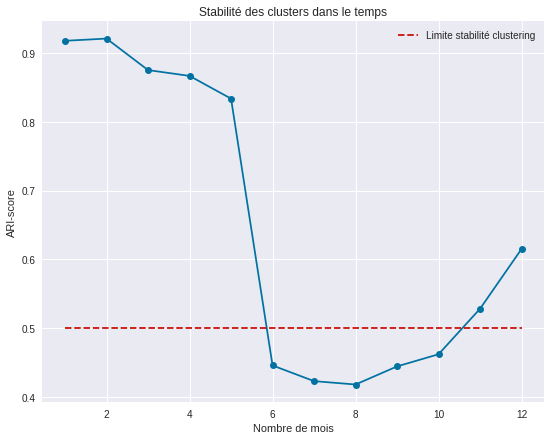

,Fréquence,Ari_score
0,1 mois,0.917949
1,2 mois,0.921183
2,3 mois,0.875335
3,4 mois,0.866876
4,5 mois,0.833754
5,6 mois,0.445493
6,7 mois,0.42268
7,8 mois,0.417775
8,9 mois,0.444116
9,10 mois,0.461813


In [63]:
stability_cluster_one_year( data,
                           ["Recency","Frequency","Monetary","review_score"],
                                          n_cluster =5 ,recence_col = "Recency")

On regarde notre dataset sur la même période qu'au dessus plus 6 mois et on recalcule R,F,M étant donné qu'on a des utilisateurs qui se sont rajoutés. On voit une chute de l'ARI au bout de 7 mois au lieu de 6 mois.

En perspective, on peut regarder l'évolution de l'ARI sur une période T et y rajouter des mois progressivement pour observer l'évolution de nos clusterings et voir si un contrat de maintenance est nécessaire.

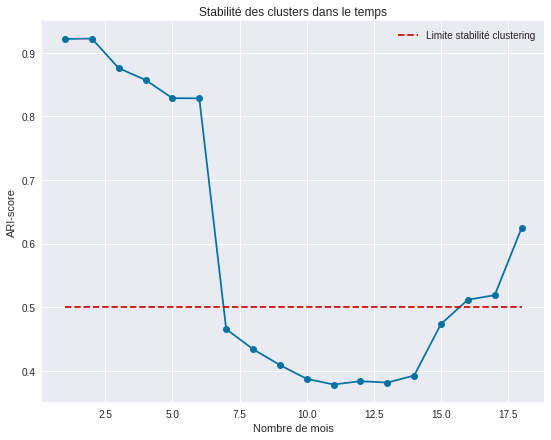

,Fréquence,Ari_score
0,1 mois,0.921871
1,2 mois,0.922413
2,3 mois,0.875802
3,4 mois,0.857307
4,5 mois,0.828637
5,6 mois,0.828444
6,7 mois,0.465491
7,8 mois,0.433968
8,9 mois,0.408947
9,10 mois,0.387262


In [64]:
stability_cluster_one_year_delayed( data_variables,
                           ["Recency","Frequency","Monetary","review_score"],
                                          n_cluster =5 ,recence_col = "Recency")